# Interactive Slider for GradCAM Heatmap

Plots an interactive slider for GradCAM heatmaps for all models for a given patient.

### Import Libraries and Modules

In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.2.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
INPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
OUTPUT_DIR = "/tf/notebooks/bule/explainable_AI/"
if os.getcwd() != OUTPUT_DIR:
    os.chdir(OUTPUT_DIR)
    
import functions_model_definition as md
import functions_read_data as rdat
import functions_slider as sl

/tf


Using TensorFlow backend.


## Load Data and Set Up Model

In [3]:
# Define Version
version = "10Fold_CIBLSX" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
# 10Fold_CIB, 10Fold_CIBLSX

# Define Model Version
model_version = 1

# define weighting
hm_mode = "wgt" 

# define heatmap type
hm_type = "gc"
pred_hm_only = False

# Define if plots should be saved
save_plot = False

# define paths
DATA_DIR, WEIGHT_DIR, DATA_OUTPUT_DIR, PIC_OUTPUT_DIR, pic_save_name = rdat.dir_setup(
    INPUT_DIR, OUTPUT_DIR, version, model_version, weight_mode = hm_mode,
    hm_type = hm_type, ending = "_predcl" if pred_hm_only else "_bothcl")

In [4]:
## load images and ids
(X_in, pat_id, id_tab, all_results_tab, pat_orig_tab, pat_norm_tab, num_models) = rdat.version_setup(
    DATA_DIR = DATA_DIR, version = version, model_version = model_version)

## Define Model

In [5]:
# define model
(input_dim_img, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)

model_3d = md.model_init(
    version = version, 
    output_dim = output_dim,
    LOSS = LOSS,
    layer_connection = layer_connection,
    last_activation = last_activation,
    C = 2,
    learning_rate = 5*1e-5,
    batch_size = 6,
    input_dim = input_dim_img,
    input_dim_tab = pat_norm_tab.drop(columns=["p_id"]).shape[1] if "LSX" in version else None,
)

In [6]:
# Define Model Name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR)  

# GradCam Slider

patient id:  471
age:  87
true mrs:  3.0
true class:  1
pred class: 1
pred prob (class 1):  0.24266011427514955
pred uncertainty:  0.37940127
max slices: (23, 107, 83)


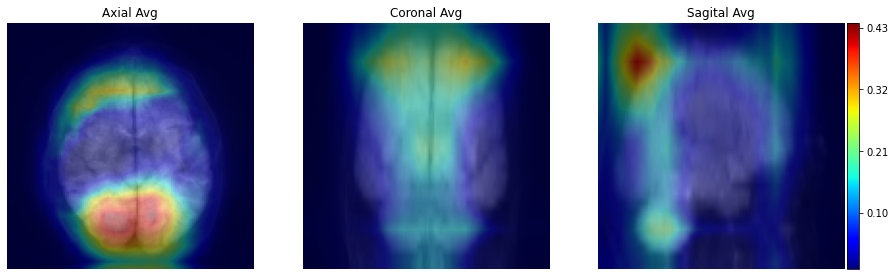

In [7]:
sl.gradcam_interactive_plot(
    471, # patient id
    vis_layers=md.get_last_conv_layer(model_3d),
    cnn=model_3d, all_results=all_results_tab, pat=pat_id, X_in=X_in,
    generate_model_name=generate_model_name, num_models=num_models,
    pat_dat=pat_orig_tab,
    pred_hm_only=True) # if False, also negative heatmap is shown
